## EDA - Superstore dataset
Business task: A retail company wants to improve profitability by understanding sales performance, customer satisfaction, profits structure and loss-making segments across product categories, states, and discount strategies.

The following questions are formulated in order to provide complete answer:  
__Question 1__: Which states generate high sales and profit and which underperform in profitability?  
__Question 2__: How does profit distribution differ across product categories?  
__Question 3__: Are higher discounts correlated with increased sales volume? With increasing profit?  
__Question 4__: Evaluate quality of "First class" and "Same Day" categories of shipping. Is there a difference between 'First class" shipping time and other shipping modes? Are "Same Day" orders indeed shipped on the same day?

In [38]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import ranksums
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn
from cliffs_delta import cliffs_delta
import math
import plotly.express as px
from scipy.stats import spearmanr

In [39]:
#functions

def count_outliers_iqr(df, columns):
    outlier_counts = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_counts[col] = outlier_count

    return outlier_counts 

def norm_check(data, name):
    shapiro_test = stats.shapiro(data)
    print(f"Shapiro-Wilk test for {name}: {shapiro_test}")
    alpha = 0.05
    if shapiro_test.pvalue > alpha:
        print(f"For {name}, we cannot reject the null hypothesis of normality (p = {shapiro_test.pvalue:.5f}).")
    else:
        print(f"For {name}, we reject the null hypothesis of normality (p = {shapiro_test.pvalue:.5f}).")

state_to_abbrev = {
    "Alabama": "AL",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "District of Columbia": "DC",
    "Florida": "FL",
    "Georgia": "GA",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
}

In [40]:
df_superstore = pd.read_csv("Sample - Superstore.csv")
print(df_superstore.head())
print(df_superstore.info())

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688   6/12/2016   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ... Region  \
0      Claire Gute   Consumer  United States        Henderson  ...  South   
1      Claire Gute   Consumer  United States        Henderson  ...  South   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   West   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...  South   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...  South   

        Product ID         Category Sub-Category  

## Data cleansing and modification

In [41]:
#Printing unique values for categorical columns
print("Segment: ",df_superstore["Segment"].unique())
print("Country: ",df_superstore["Country"].unique())
print("City: ",df_superstore["City"].unique())
print("State: ",df_superstore["State"].unique())
print("Region: ",df_superstore["Region"].unique())
print("Category: ",df_superstore["Category"].unique())
print("Sub-Category: ",df_superstore["Sub-Category"].unique())

Segment:  ['Consumer' 'Corporate' 'Home Office']
Country:  ['United States']
City:  ['Henderson' 'Los Angeles' 'Fort Lauderdale' 'Concord' 'Seattle'
 'Fort Worth' 'Madison' 'West Jordan' 'San Francisco' 'Fremont'
 'Philadelphia' 'Orem' 'Houston' 'Richardson' 'Naperville' 'Melbourne'
 'Eagan' 'Westland' 'Dover' 'New Albany' 'New York City' 'Troy' 'Chicago'
 'Gilbert' 'Springfield' 'Jackson' 'Memphis' 'Decatur' 'Durham' 'Columbia'
 'Rochester' 'Minneapolis' 'Portland' 'Saint Paul' 'Aurora' 'Charlotte'
 'Orland Park' 'Urbandale' 'Columbus' 'Bristol' 'Wilmington' 'Bloomington'
 'Phoenix' 'Roseville' 'Independence' 'Pasadena' 'Newark' 'Franklin'
 'Scottsdale' 'San Jose' 'Edmond' 'Carlsbad' 'San Antonio' 'Monroe'
 'Fairfield' 'Grand Prairie' 'Redlands' 'Hamilton' 'Westfield' 'Akron'
 'Denver' 'Dallas' 'Whittier' 'Saginaw' 'Medina' 'Dublin' 'Detroit'
 'Tampa' 'Santa Clara' 'Lakeville' 'San Diego' 'Brentwood' 'Chapel Hill'
 'Morristown' 'Cincinnati' 'Inglewood' 'Tamarac' 'Colorado Springs'
 'B

In [42]:
#removing unnessesary columns
df_superstore.drop(columns=['Unnamed: 21'], inplace=True)
df_superstore.drop(columns=['Country'], inplace=True)

In [43]:
#removing invalid values
invalid_rows = df_superstore[df_superstore['Sales'].str.contains(r'[^0-9.]', na=False, regex=True)]
print(invalid_rows["Sales"])
df_superstore = df_superstore[~df_superstore['Sales'].str.contains(r'[^0-9.]', na=False, regex=True)]
invalid_rows = df_superstore[df_superstore['Sales'].str.contains(r'[^0-9.]', na=False, regex=True)]
print(invalid_rows["Sales"])

181      16GB
430      16GB
431      16GB
1406     16GB
1969     16GB
1971     16GB
Name: Sales, dtype: object
Series([], Name: Sales, dtype: object)


In [44]:
# changing datatypes of columns, creating new column
df_superstore["Order Date"] = pd.to_datetime(df_superstore["Order Date"], format="%m/%d/%Y")
df_superstore["Ship Date"] = pd.to_datetime(df_superstore["Ship Date"], format="%m/%d/%Y")
df_superstore["Sales"] = pd.to_numeric(df_superstore["Sales"])
df_superstore["Shipping Time"] = df_superstore["Ship Date"]-df_superstore["Order Date"]
df_superstore["Shipping Time"]=df_superstore["Shipping Time"].dt.total_seconds() / 86400

In [45]:
print(df_superstore.isna().any().any())
missing_rows = df_superstore[df_superstore.isna().any(axis=1)]
print(missing_rows)

False
Empty DataFrame
Columns: [Row ID, Order ID, Order Date, Ship Date, Ship Mode, Customer ID, Customer Name, Segment, City, State, Postal Code, Region, Product ID, Category, Sub-Category, Product Name, Sales, Quantity, Discount, Profit, Shipping Time]
Index: []

[0 rows x 21 columns]


In [46]:
#checking on outliers using quantile method
columns_to_check = ["Profit","Sales",'Discount','Quantity',]
outliers_ = count_outliers_iqr(df_superstore, columns_to_check)
print(outliers_)

{'Profit': np.int64(1877), 'Sales': np.int64(1167), 'Discount': np.int64(856), 'Quantity': np.int64(170)}


In [47]:
columns_to_describe = ["Sales", "Profit", "Discount","Quantity"]
stats_table = df_superstore[columns_to_describe].describe()
stats_table.style.set_caption("Descriptive Statistics for the Quantitative Columns")

# outliers seem to be valid observations so no deletion or further manipulation is needed

,Sales,Profit,Discount,Quantity
count,9988.000000,9988.000000,9988.000000,9988.000000
mean,229.803156,28.633188,0.156196,3.788646
std,623.422931,234.327679,0.206506,2.224976
min,0.444000,-6599.978000,0.000000,1.000000
25%,17.248000,1.727550,0.000000,2.000000
50%,54.376000,8.641350,0.200000,3.000000
75%,209.880000,29.341200,0.200000,5.000000
max,22638.480000,8399.976000,0.800000,14.000000


## Question 1

<Figure size 1200x600 with 0 Axes>

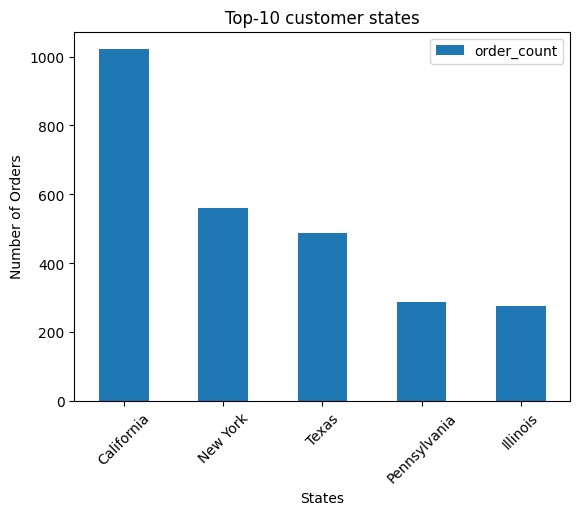

<Figure size 1200x600 with 0 Axes>

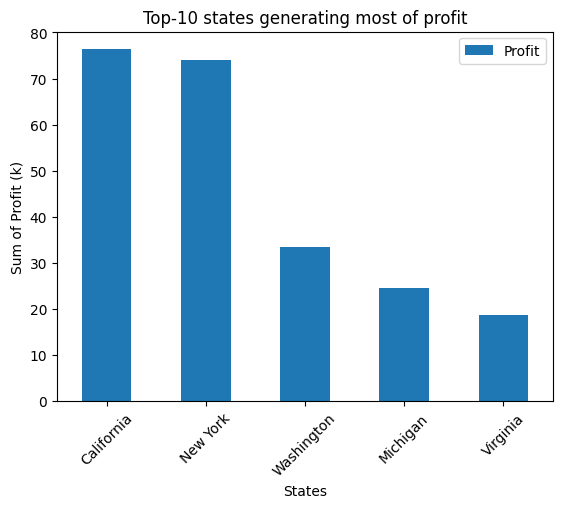

<Figure size 1200x600 with 0 Axes>

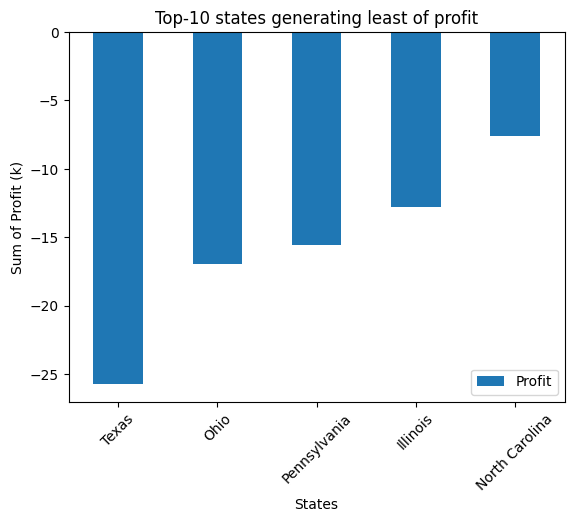

In [48]:
state_orders = (
    df_superstore.groupby("State")["Order ID"]
      .nunique()
      .reset_index(name="order_count")
)

state_orders["state_code"] = state_orders["State"].map(state_to_abbrev)
fig_states = px.choropleth(
    state_orders,
    locations="state_code",
    locationmode="USA-states",
    color="order_count",
    scope="usa",
    color_continuous_scale="Blues",
    title="Order Distribution by State"
)
fig_states.show()


state_orders_plt=state_orders.sort_values(by="order_count", ascending=False).head(5)
plt.figure(figsize=(12, 6))
state_orders_plt.plot(kind="bar", x="State",y="order_count")
plt.xlabel("States")
plt.ylabel("Number of Orders")
plt.title("Top-10 customer states")
plt.xticks(rotation=45)
plt.show()


state_profit = (df_superstore.groupby("State")["Profit"].sum()
      .reset_index(name="Profit")
)
state_profit["Profit"]=(state_profit["Profit"]/1000).round(2)
state_profit["state_code"] = state_profit["State"].map(state_to_abbrev)
fig_states = px.choropleth(
    state_profit,
    locations="state_code",
    locationmode="USA-states",
    color="Profit",
    scope="usa",
    color_continuous_scale="Blues",
    title="Profit Distribution by State"
)
fig_states.show()


state_profit_plt=state_profit.sort_values(by="Profit",ascending=False).head(5)
plt.figure(figsize=(12, 6))
state_profit_plt.plot(kind="bar", x="State",y="Profit")
plt.xlabel("States")
plt.ylabel("Sum of Profit (k)")
plt.title("Top-10 states generating most of profit")
plt.xticks(rotation=45)
plt.show()

state_profit_plt=state_profit.sort_values(by="Profit",ascending=True).head(5)
plt.figure(figsize=(12, 6))
state_profit_plt.plot(kind="bar", x="State",y="Profit")
plt.xlabel("States")
plt.ylabel("Sum of Profit (k)")
plt.title("Top-10 states generating least of profit")
plt.xticks(rotation=45)
plt.show()

## Question 2

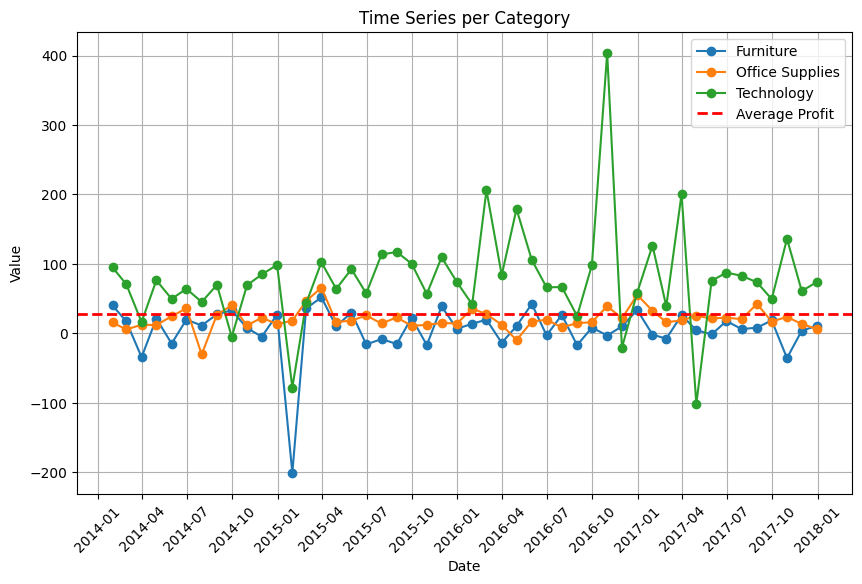

In [49]:
df_grouped = (
    df_superstore.groupby(["Category", pd.Grouper(key="Order Date", freq="ME")])["Profit"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(10, 6))

for cat, data in df_grouped.groupby("Category"):
    plt.plot(data["Order Date"], data["Profit"], label=cat, marker="o")
plt.axhline(
    y=df_superstore["Profit"].mean(),
    linestyle="--",
    linewidth=2,
    label=f"Average Profit",
    color="red"
)
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Time Series per Category")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m")) 
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.show()

In [50]:
df_furniture=df_superstore[df_superstore['Category'] == 'Furniture']
df_office=df_superstore[df_superstore['Category'] == 'Office Supplies']
df_tech=df_superstore[df_superstore['Category'] == 'Technology']

print(df_furniture.shape)
print(df_office.shape)
print(df_tech.shape)


(2121, 21)
(6026, 21)
(1841, 21)


In [51]:
norm_check(df_furniture["Profit"], "profit generated by Furniture category")
norm_check(df_office["Profit"], "profit generated by Office Supplies category")
norm_check(df_tech["Profit"],  "profit generated by Technology category")

Shapiro-Wilk test for profit generated by Furniture category: ShapiroResult(statistic=np.float64(0.6789481046281429), pvalue=np.float64(4.8829470930652865e-53))
For profit generated by Furniture category, we reject the null hypothesis of normality (p = 0.00000).
Shapiro-Wilk test for profit generated by Office Supplies category: ShapiroResult(statistic=np.float64(0.22565258491288454), pvalue=np.float64(8.877067319184911e-95))
For profit generated by Office Supplies category, we reject the null hypothesis of normality (p = 0.00000).
Shapiro-Wilk test for profit generated by Technology category: ShapiroResult(statistic=np.float64(0.28366092638217577), pvalue=np.float64(1.7867897799527537e-64))
For profit generated by Technology category, we reject the null hypothesis of normality (p = 0.00000).


c:\Users\MSI\miniconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6026.



In [52]:
H_stat, p_value = kruskal(df_furniture["Profit"], df_office["Profit"], df_tech["Profit"])
print(f"Kruskal-Wallis H Statistic: {H_stat}")
print(f"p-value: {p_value}")

data = [df_furniture["Profit"], df_office["Profit"], df_tech["Profit"]]
posthoc_results = posthoc_dunn(data, p_adjust='bonferroni')
print(posthoc_results)

d_12, _ = cliffs_delta(df_furniture["Profit"], df_office["Profit"])
d_13, _ = cliffs_delta(df_furniture["Profit"], df_tech["Profit"])
d_23, _ = cliffs_delta(df_office["Profit"], df_tech["Profit"])

print(f"Cliff's Delta (Group 1 vs Group 2): {d_12}")
print(f"Cliff's Delta (Group 1 vs Group 3): {d_13}")
print(f"Cliff's Delta (Group 2 vs Group 3): {d_23}")

Kruskal-Wallis H Statistic: 440.61456202039966
p-value: 2.0977973582068415e-96
              1             2             3
1  1.000000e+00  1.372915e-01  9.708760e-73
2  1.372915e-01  1.000000e+00  2.137710e-86
3  9.708760e-73  2.137710e-86  1.000000e+00
Cliff's Delta (Group 1 vs Group 2): -0.04070198400049573
Cliff's Delta (Group 1 vs Group 3): -0.29495966590528844
Cliff's Delta (Group 2 vs Group 3): -0.31709919697966427


## Question 3

In [53]:
norm_check(df_furniture['Discount'], "discounts")
norm_check(df_furniture["Quantity"], "quantity")

Shapiro-Wilk test for discounts: ShapiroResult(statistic=np.float64(0.833269404389239), pvalue=np.float64(1.6587561188847153e-42))
For discounts, we reject the null hypothesis of normality (p = 0.00000).
Shapiro-Wilk test for quantity: ShapiroResult(statistic=np.float64(0.8751082466603803), pvalue=np.float64(3.024343483884741e-38))
For quantity, we reject the null hypothesis of normality (p = 0.00000).


In [54]:
filtered_data = df_superstore[df_superstore["Discount"] != 0]
rho, p_value = stats.spearmanr(filtered_data['Discount'], filtered_data['Quantity'])
rho_1, p_value_1 = stats.spearmanr(df_superstore['Discount'], df_superstore['Quantity'])
print(f"Spearman's correlation coefficient for filtered data (0 discounts are not taken into account): {rho}")
print(f"P-value for filtered data (0 discounts are not taken into account): {p_value}")
print(f"Spearman's correlation coefficient for non-filtered observations: {rho_1}")
print(f"P-value for for non-filtered observations: {p_value_1}")


Spearman's correlation coefficient for filtered data (0 discounts are not taken into account): 0.03333437178905858
P-value for filtered data (0 discounts are not taken into account): 0.01631535336712304
Spearman's correlation coefficient for non-filtered observations: -0.0011103700654680724
P-value for for non-filtered observations: 0.9116508338746381


In [55]:
corr, p_value = spearmanr(df_superstore["Profit"], df_superstore["Discount"])

print(f"Spearman r: {corr:.3f}")
print(f"p-value: {p_value:.4g}")

df_no_disc=df_superstore[df_superstore["Discount"]==0]
df_small_disc=df_superstore[(df_superstore["Discount"]>0) & (df_superstore["Discount"]<0.5)]
df_large_disc=df_superstore[(df_superstore["Discount"]>0.5)]

H_stat, p_value_k = kruskal(df_no_disc["Profit"], df_small_disc["Profit"], df_large_disc["Profit"])
print(f"Kruskal-Wallis H Statistic: {H_stat}")
print(f"p-value: {p_value_k}")

data = [df_no_disc["Profit"], df_small_disc["Profit"], df_large_disc["Profit"]]
posthoc_results = posthoc_dunn(data, p_adjust='bonferroni')
print(posthoc_results)

d_12, _ = cliffs_delta(df_no_disc["Profit"], df_small_disc["Profit"])
d_13, _ = cliffs_delta(df_no_disc["Profit"], df_large_disc["Profit"])
d_23, _ = cliffs_delta(df_small_disc["Profit"], df_large_disc["Profit"])

print(f"Cliff's Delta (Group 1 vs Group 2): {d_12}")
print(f"Cliff's Delta (Group 1 vs Group 3): {d_13}")
print(f"Cliff's Delta (Group 2 vs Group 3): {d_23}")

Spearman r: -0.544
p-value: 0
Kruskal-Wallis H Statistic: 2765.3587889504165
p-value: 0.0


               1              2              3
1   1.000000e+00  1.588952e-213   0.000000e+00
2  1.588952e-213   1.000000e+00  3.910716e-212
3   0.000000e+00  3.910716e-212   1.000000e+00
Cliff's Delta (Group 1 vs Group 2): 0.3897690604921978
Cliff's Delta (Group 1 vs Group 3): 1.0
Cliff's Delta (Group 2 vs Group 3): 0.7315377323586911


## Question 4

                 count      mean       std  min  25%  50%  75%  max
Ship Mode                                                          
First Class     1537.0  2.182824  0.773767  1.0  2.0  2.0  3.0  4.0
Same Day         543.0  0.044199  0.205726  0.0  0.0  0.0  0.0  1.0
Second Class    1944.0  3.237654  1.188425  1.0  2.0  3.0  4.0  5.0
Standard Class  5964.0  5.006036  1.010907  3.0  4.0  5.0  6.0  7.0


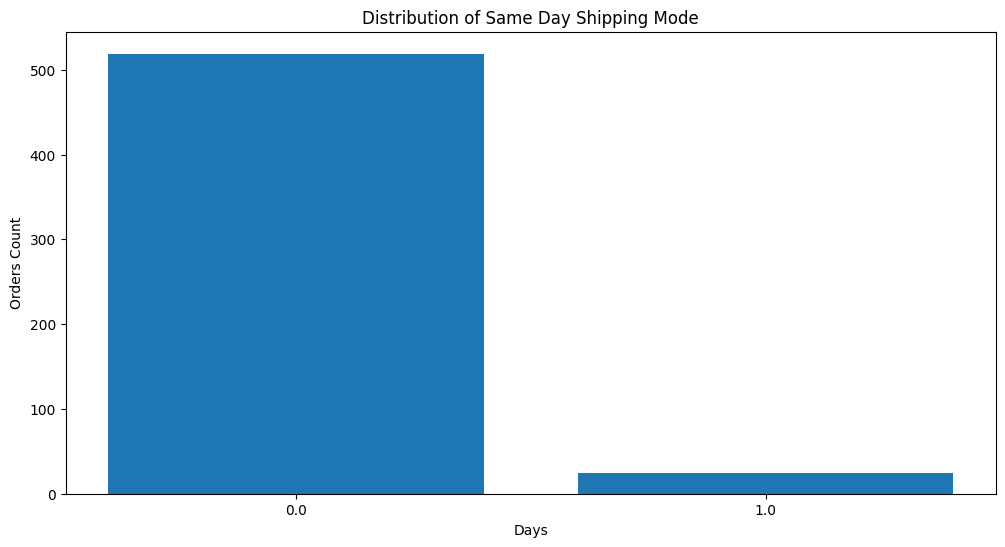

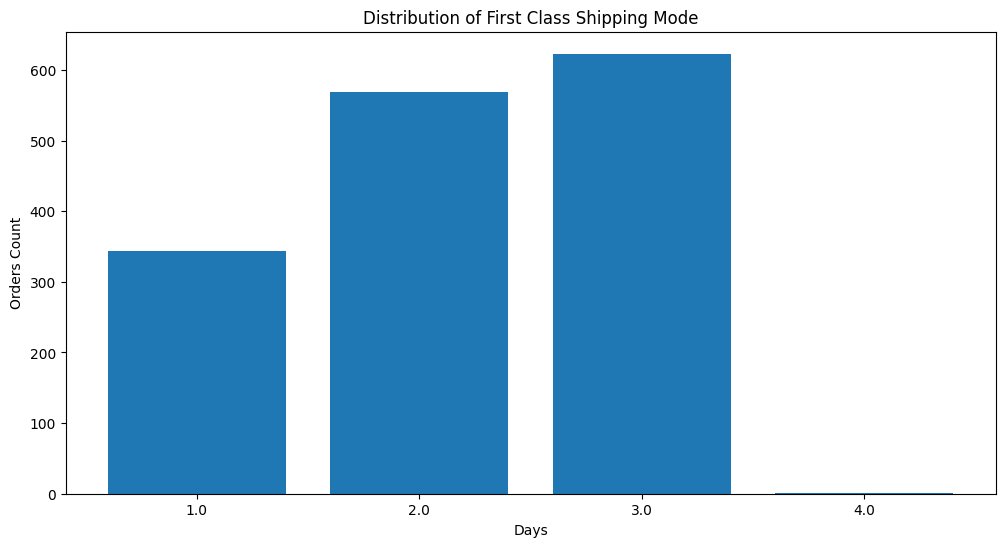

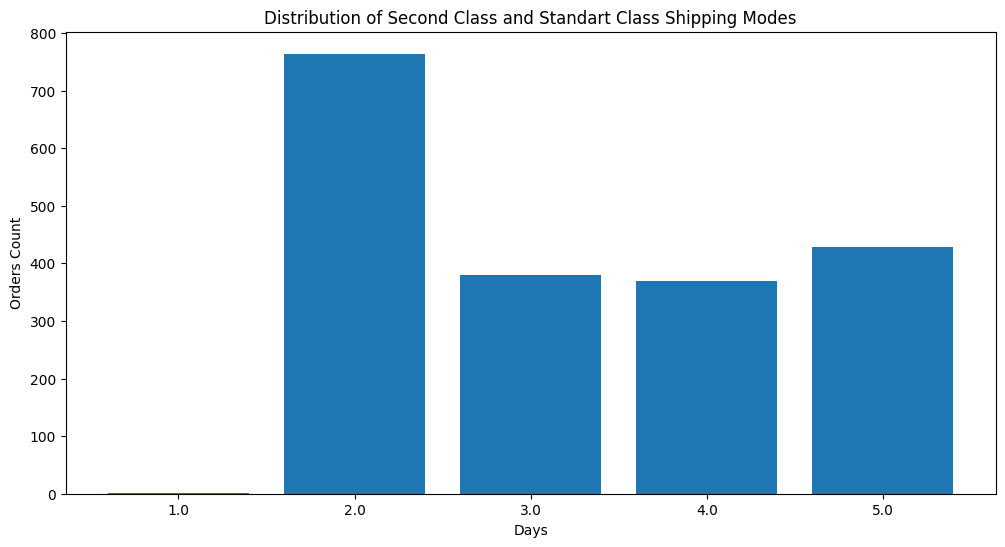

In [56]:
print(df_superstore.groupby("Ship Mode")["Shipping Time"].describe())
df_same_day= df_superstore[df_superstore['Ship Mode'] == 'Same Day']

counts = df_same_day['Shipping Time'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Days")
plt.ylabel("Orders Count")
plt.title("Distribution of Same Day Shipping Mode")
plt.show()

df_first_class = df_superstore[df_superstore['Ship Mode'] == 'First Class']
df_regular_shipping = df_superstore[(df_superstore['Ship Mode'] == 'Second Class') | (df_superstore['Ship Mode'] == 'Standart Class')]

counts = df_first_class['Shipping Time'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Days")
plt.ylabel("Orders Count")
plt.title("Distribution of First Class Shipping Mode")
plt.show()

counts = df_regular_shipping['Shipping Time'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Days")
plt.ylabel("Orders Count")
plt.title("Distribution of Second Class and Standart Class Shipping Modes")
plt.show()

In [57]:
norm_check(df_first_class["Shipping Time"], "first class shipping")
norm_check(df_regular_shipping["Shipping Time"], "regular shipping")


U_stat, p_value= mannwhitneyu(df_first_class["Shipping Time"], df_regular_shipping["Shipping Time"], alternative='less')
print("Mann-Whitney test statistic:", U_stat, ", p-value: ",p_value)
n1 = len(df_first_class["Shipping Time"])
n2 = len(df_regular_shipping["Shipping Time"])
r = 1 - (2 * U_stat) / (n1 * n2)
print(f"Effect Size (r): {r}")

Shapiro-Wilk test for first class shipping: ShapiroResult(statistic=np.float64(0.7937080697107866), pvalue=np.float64(2.2758294829338705e-40))
For first class shipping, we reject the null hypothesis of normality (p = 0.00000).
Shapiro-Wilk test for regular shipping: ShapiroResult(statistic=np.float64(0.8142178650107137), pvalue=np.float64(1.0948168936719996e-42))
For regular shipping, we reject the null hypothesis of normality (p = 0.00000).
Mann-Whitney test statistic: 814394.0 , p-value:  8.457058034056316e-129
Effect Size (r): 0.45487709208521754


## Answers to business questions
__Question 1:__ States where situation is positive are California, New York and Washington -  there are a lot of orders coming from those states and they generate the biggest amount of profit. Alarming states are Texas, Pennsylvania and Illinois - they generate significant share of orders but show negative profit. To improve the current situation there should be reduction eiher in number of orders from unprofitable states or their yield should be somehow raised.  

__Question 2:__ In terms of profit generated by product categories average profit generated from ***Office Supplies*** category is the most stable one and shows little oscillations throughout all period of observation. That is logical - no obvious external factors could affect the demand of supplies. ***Furniture profit*** is also mostly stable excluding one large decrease on the 2015-02. Both of those categories perform close to the average profit value.***Technology*** category demonstrates most unstable average profit with highest peaks in the time period 2016-03 - 2017-04. Statistical tests prove that profit generated by ***Technology*** is larger than other categories. Therefore, products from ***Technology*** section should be promoted and customers should be encouraged to buy them in order to enlarge profit received.  

__Question 3:__ In general, there is no difference between quantity of products bought with or without discount. However larger discounts indeed encourage people to buy more. In terms of profit generation, discounts tend to decrease profit, especially large ones. Taking that into account, our discount policy should be adjusted and testing period at least without large discounts (more than 0.5) should be applied to compare performance.  

__Question 4:__ ***Same Day*** mode of shipping performes as desired: shipping is made on the same day or next day and same day case is dominant. The fact that sometimes shipping occurs on the next day could reflect situation when order is received in the late night hours or on Sunday. Dataset doesn't provide time in the variables to confirm those guesses. ***First Class*** Mode of shipping also demonstrates much faster delivery time than ***Second Class*** and ***Standart Class*** modes. On average orders arrive faster as confirmed by the statistical test, making this shipping mode reasonable. To conclude, no actions in terms of improving shipping modes are needed. 